In [1]:
import pandas as pd
import config

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pickle
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_parquet('../data/processed/scores_approvals_2020_2022.parquet')
df2 = pd.read_parquet('../data/processed/scores_approvals_2019_2021_new.parquet')
approvals_stats = pd.read_parquet('../data/interim/approved_stats_2019_2021_new.parquet')

In [3]:
print(df.shape)
df = pd.merge(df, approvals_stats, on='course', how='left')
print(df.shape)
df['dist_min'] = df['pseudo_argumento_final'] - df['min']
df['min_flag'] = df['pseudo_argumento_final'] > df['min']

df['dist_max'] = df['pseudo_argumento_final'] - df['max']
df['dist_median'] = df['pseudo_argumento_final'] - df['median']

df['dist_mean'] = df['pseudo_argumento_final'] - df['mean']
df['mean_flag'] = df['pseudo_argumento_final'] > df['mean']

(7263, 41)
(7263, 46)


In [4]:
FEATURES = [
            'escore_bruto_p1_etapa1',
            'escore_bruto_p2_etapa1',
            'nota_redacao_etapa1',
            'escore_bruto_p1_etapa2',
            'escore_bruto_p2_etapa2',
            'nota_redacao_etapa2',
            'escore_bruto_p1_etapa3',
            'escore_bruto_p2_etapa3',
            'nota_redacao_etapa3',
            'pseudo_argumento_final',
            'dist_min',
            #'dist_max',
            'dist_mean',
            'dist_median',
            #'cotista',
            'cotas_negros_flag',
            'publicas_flag',
            'publicas1_flag',
            'publicas2_flag',
            'publicas3_flag',
            'publicas4_flag',
            'publicas5_flag',
            'publicas6_flag',
            'publicas7_flag',
            'publicas8_flag'
            #'dist_min',
            #'dist_max',
            #'dist_mean',
            #'dist_median',
            #'course'
            ]

In [5]:
df = pd.get_dummies(df, columns=['course', 'min_flag', 'mean_flag'], drop_first=True)

In [6]:
dummies = [feature for feature in df.columns if 'course_' in feature]
dummies.append('min_flag_True')
dummies.append('mean_flag_True')

In [7]:
FEATURES.extend(dummies)
len(FEATURES)

115

In [8]:
shuffled_df = df.sample(frac=1, random_state=42)
X = shuffled_df[FEATURES] # features
y = shuffled_df['label'] # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47) # 70% training and 30% test

print(X_train.shape)
print(y_train.shape)

(5810, 115)
(5810,)


In [9]:
X_train = X_train.fillna(0)

In [10]:
y_train.value_counts(normalize=True)

0    0.823408
1    0.176592
Name: label, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.814178
1    0.185822
Name: label, dtype: float64

In [12]:
print(df2.shape)
df2 = pd.merge(df2, approvals_stats, on='course', how='left')
print(df2.shape)
df2['dist_min'] = df2['pseudo_argumento_final'] - df2['min']
df2['min_flag'] = df2['pseudo_argumento_final'] > df2['min']

df2['dist_max'] = df2['pseudo_argumento_final'] - df2['max']
df2['dist_median'] = df2['pseudo_argumento_final'] - df2['median']

df2['dist_mean'] = df2['pseudo_argumento_final'] - df2['mean']
df2['mean_flag'] = df2['pseudo_argumento_final'] > df2['mean']

df2 = pd.get_dummies(df2, columns=['course', 'min_flag', 'mean_flag'], drop_first=True)
df2['course_MÚSICA (BACHARELADO)'] = 0


df2_shuffled = df2.sample(frac=1, random_state=42)

(8572, 41)
(8572, 46)


In [13]:
X_train = pd.concat([X_train, df2_shuffled[FEATURES]])
y_train = pd.concat([y_train, df2_shuffled['label']])

print(X_train.shape)
print(y_train.shape)

(14382, 115)
(14382,)


In [14]:
y_test.value_counts()

0    1183
1     270
Name: label, dtype: int64

In [15]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [16]:
columns_to_standardize = list(X_train.columns[:11])  # Example: standardizing columns 0 and 2
columns_to_standardize

['escore_bruto_p1_etapa1',
 'escore_bruto_p2_etapa1',
 'nota_redacao_etapa1',
 'escore_bruto_p1_etapa2',
 'escore_bruto_p2_etapa2',
 'nota_redacao_etapa2',
 'escore_bruto_p1_etapa3',
 'escore_bruto_p2_etapa3',
 'nota_redacao_etapa3',
 'pseudo_argumento_final',
 'dist_min']

In [17]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [18]:
# Standardize the selected columns in the training and test data
scaler = StandardScaler()
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

In [19]:
y_train.value_counts()

0    11260
1     3122
Name: label, dtype: int64

In [20]:
# Create a Logistic Regression model
model = LogisticRegressionCV(solver='liblinear', cv=5, class_weight={0:1, 1:2}, max_iter=100)
#model = LogisticRegressionCV(solver='liblinear', cv=5, max_iter=100)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.956482320942883,
  'recall': 0.8918005071851226,
  'f1-score': 0.9230096237970254,
  'support': 1183},
 '1': {'precision': 0.6342857142857142,
  'recall': 0.8222222222222222,
  'f1-score': 0.7161290322580646,
  'support': 270},
 'accuracy': 0.8788713007570543,
 'macro avg': {'precision': 0.7953840176142986,
  'recall': 0.8570113647036723,
  'f1-score': 0.819569328027545,
  'support': 1453},
 'weighted avg': {'precision': 0.8966109625138151,
  'recall': 0.8788713007570543,
  'f1-score': 0.8845665682460828,
  'support': 1453}}

In [21]:
# Make predictions on the test set
y_pred = model.predict_proba(X_test)[:, 1] > .7

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9066558441558441,
  'recall': 0.9442096365173288,
  'f1-score': 0.9250517598343685,
  'support': 1183},
 '1': {'precision': 0.7013574660633484,
  'recall': 0.5740740740740741,
  'f1-score': 0.6313645621181262,
  'support': 270},
 'accuracy': 0.8754301445285616,
 'macro avg': {'precision': 0.8040066551095962,
  'recall': 0.7591418552957014,
  'f1-score': 0.7782081609762473,
  'support': 1453},
 'weighted avg': {'precision': 0.8685067993623314,
  'recall': 0.8754301445285616,
  'f1-score': 0.8704780892332774,
  'support': 1453}}

In [22]:
import numpy as np

In [23]:
odds = np.exp(model.coef_[0])
pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
publicas8_flag,481.574947
course_ARTES VISUAIS (LICENCIATURA),22.792754
course_LICENCIATURA EM FÍSICA,22.410042
publicas7_flag,19.171006
course_LÍNGUA E LITERATURA JAPONESA (LICENCIATURA),16.102656
course_MÚSICA (LICENCIATURA),14.141951
publicas6_flag,7.871438
course_MUSEOLOGIA (BACHARELADO),7.341946
course_FÍSICA (BACHARELADO),6.790147
course_HISTÓRIA (LICENCIATURA),5.289873


In [27]:
#course='ENGENHARIAS – AEROESPACIAL / AUTOMOTIVA / ELETRÔNICA / ENERGIA / SOFTWARE (BACHARELADOS)'
course='course_MEDICINA (BACHARELADO)'
classification_report(y_test[X_test[course]==1], y_pred[X_test[course]==1], output_dict=True)

c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.9583333333333334,
  'recall': 1.0,
  'f1-score': 0.9787234042553191,
  'support': 138},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6},
 'accuracy': 0.9583333333333334,
 'macro avg': {'precision': 0.4791666666666667,
  'recall': 0.5,
  'f1-score': 0.48936170212765956,
  'support': 144},
 'weighted avg': {'precision': 0.9184027777777778,
  'recall': 0.9583333333333334,
  'f1-score': 0.9379432624113474,
  'support': 144}}

## Model Calibration

In [76]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [77]:
model_sigmoid = CalibratedClassifierCV(model, cv=3, method="isotonic")

In [78]:
clf_list = [(model, "XGBoost"), (model_sigmoid, "XGBoost + Isotonic")]

Text(0.5, 1.0, 'Calibration plots (XGBoost)')

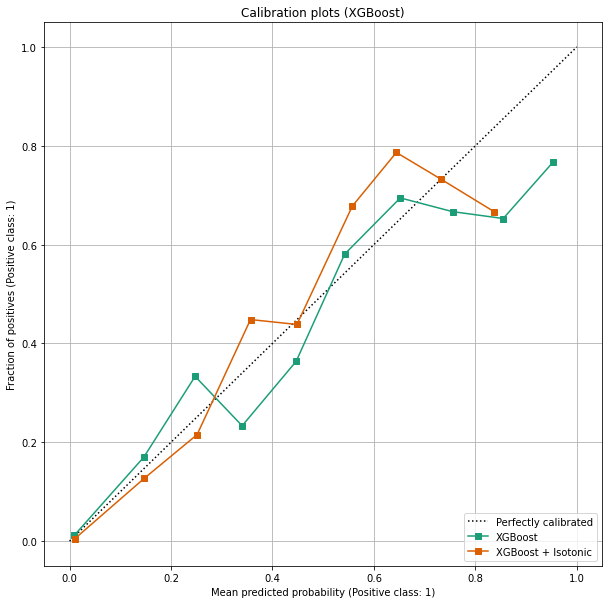

In [79]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (XGBoost)")

In [80]:
# Make predictions on the test set
y_pred = model_sigmoid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.929225645295587,
  'recall': 0.9433643279797126,
  'f1-score': 0.9362416107382552,
  'support': 1183},
 '1': {'precision': 0.7341269841269841,
  'recall': 0.6851851851851852,
  'f1-score': 0.7088122605363985,
  'support': 270},
 'accuracy': 0.8953888506538197,
 'macro avg': {'precision': 0.8316763147112856,
  'recall': 0.8142747565824489,
  'f1-score': 0.8225269356373268,
  'support': 1453},
 'weighted avg': {'precision': 0.8929719367508364,
  'recall': 0.8953888506538197,
  'f1-score': 0.8939801347888393,
  'support': 1453}}

## Prediction for new sample

In [82]:
with open('xgboost_categorical_calibrated.pickle','wb') as f:
    pickle.dump(model_sigmoid, f)

In [26]:
with open('../ml_dev/models/xgboost_categorical_calibrated.pickle', 'rb') as f:
  model_loaded = pickle.load(f)

In [83]:
def preprocess_input_features(features: dict) -> pd.DataFrame:
    new_sample = features
    new_sample = pd.DataFrame([new_sample])
    new_sample.course = new_sample.course.astype(cat_type)
    return new_sample

In [119]:
my_sample = {
"escore_bruto_p1_etapa1": 6.034,
 "escore_bruto_p2_etapa1": 64.65,
 "nota_redacao_etapa1": 9.733,
 "escore_bruto_p1_etapa2": 3.845,
 "escore_bruto_p2_etapa2": 63.826,
 "nota_redacao_etapa2": 9.933,
 "escore_bruto_p1_etapa3": 7.14,
 "escore_bruto_p2_etapa3": 76.636,
 "nota_redacao_etapa3": 9.931,
 "pseudo_argumento_final": 70.36833333333334,
 "cotista": 0,
 "cotas_negros_flag": 0,
 "publicas_flag": 0,
 "publicas1_flag": 0,
 "publicas2_flag": 0,
 "publicas3_flag": 0,
 "publicas4_flag": 0,
 "publicas5_flag": 0,
 "publicas6_flag": 0,
 "publicas7_flag": 0,
 "publicas8_flag": 0,
 "dist_min": True,
 "course": "MEDICINA (BACHARELADO)"
 }

In [116]:
my_sample = preprocess_input_features(my_sample)

In [117]:
my_sample2 = X_test.loc[[3926, 3936]]

In [118]:
print(model.predict_proba(my_sample))
print(model.predict_proba(my_sample2))
#print(model_sigmoid.predict_proba(my_sample))
#print(model_sigmoid.predict_proba(X_test.head(13)))

[[0.8205844  0.17941557]]
[[0.9960371  0.00396285]
 [0.8711974  0.1288026 ]]
